This program uses ARIMA (Auto-Regressive Integrated Moving Average), which is acutally a simple statisitcal method to analyse time series dataset. \
For a dataset which is not stationary (variance and mean changes overtime), one uses SARIMA (Seasonal ARIMA).

In [1]:
#https://youtu.be/tnaq2Ao4KBE

"""
A quick overview of timeseries. 

Dataset from: https://www.kaggle.com/rakannimer/air-passengers
International Airline Passengers prediction problem.
This is a problem where, given a year and a month, the task is to predict 
the number of international airline passengers in units of 1,000. 
The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.
"""

'\nA quick overview of timeseries. \n\nDataset from: https://www.kaggle.com/rakannimer/air-passengers\nInternational Airline Passengers prediction problem.\nThis is a problem where, given a year and a month, the task is to predict \nthe number of international airline passengers in units of 1,000. \nThe data ranges from January 1949 to December 1960, or 12 years, with 144 observations.\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
# load the dataset
df = pd.read_csv('data/AirPassengers.csv')

# Data Preparation

In [4]:
# converts column month from int64 to datetime
df['Month'] = pd.to_datetime(df['Month'])


In [5]:
# sets month column as index of dataframe
df.set_index('Month', inplace=True) 


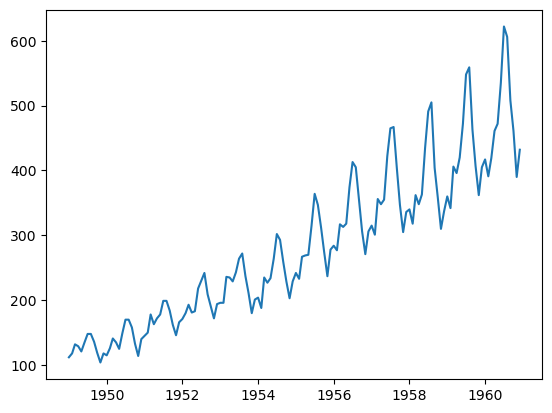

In [6]:
# plots data
plt.plot(df['Passengers'])

In [7]:
# Check whether the data is stationary 
# --> Therefore use Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")
#Since data is  non-stationary, we may need SARIMA and not just ARIMA

pvalue =  0.991880243437641  if above 0.05, data is not stationary


In [8]:
# Since index columns is already converted to datetime format, one can easily select year, month, week, day, hour, minute, second
df['year'] = df.index.year
df['month'] = df.index.month

In [9]:
years = df['year'].unique()
years

array([1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960], dtype=int64)

# Data Exploration

<Axes: xlabel='year', ylabel='Passengers'>

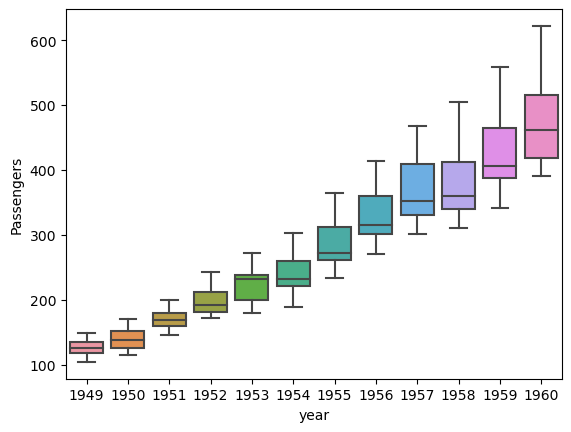

In [10]:
#Plot yearly and monthly values as boxplot
sns.boxplot(x='year', y='Passengers', data=df)


<Axes: xlabel='month', ylabel='Passengers'>

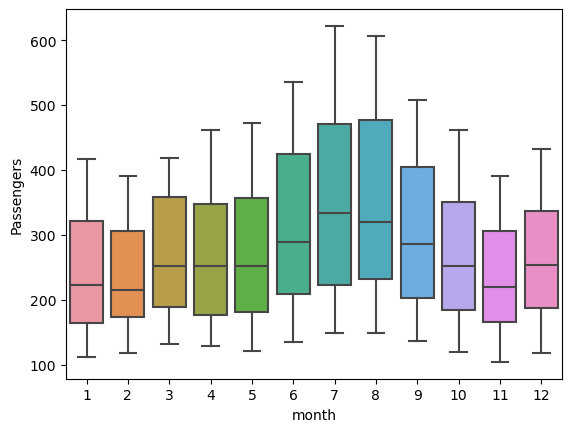

In [11]:
sns.boxplot(x='month', y='Passengers', data=df)

In [12]:
# One can extract the trends and seasonality within the data by using the following 
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df['Passengers'],  
                            model ='additive')

In [13]:
# There can be different time series types
"""
Additive time series:
Value = Base Level + Trend + Seasonality + Error
Multiplicative Time Series:
Value = Base Level x Trend x Seasonality x Error

"""

'\nAdditive time series:\nValue = Base Level + Trend + Seasonality + Error\nMultiplicative Time Series:\nValue = Base Level x Trend x Seasonality x Error\n\n'

In [14]:
# From the imported module "seasonal_decompose" one can extract the trend, seasonal, and residual 
trend = decomposed.trend
seasonal = decomposed.seasonal #Cyclic behavior may not be seasonal!
residual = decomposed.resid

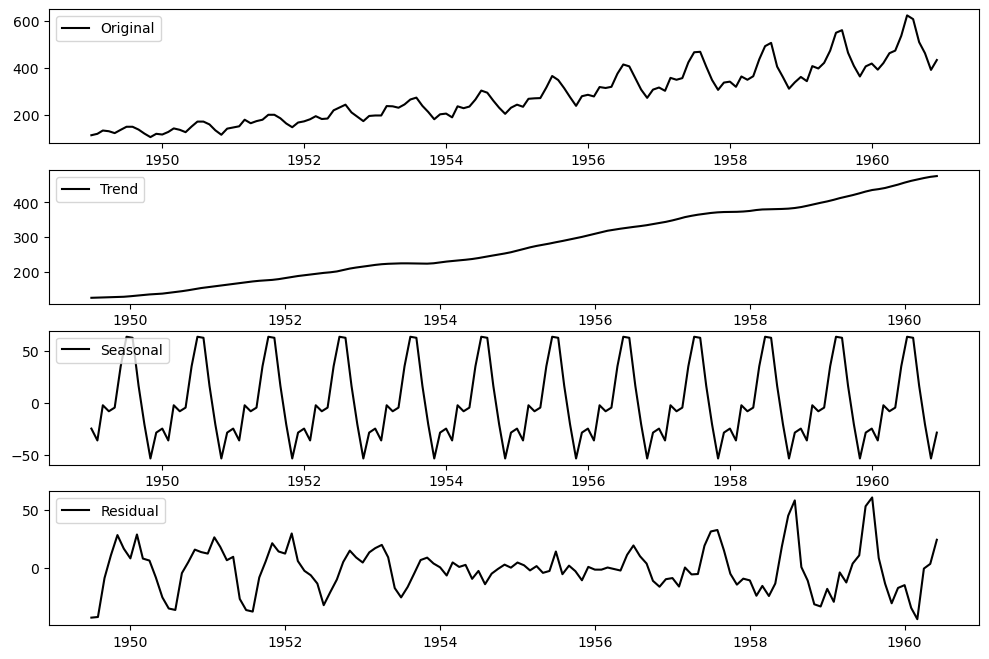

In [15]:
# Plot all Data Explorations
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df['Passengers'], label='Original', color='black')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='black')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='black')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='black')
plt.legend(loc='upper left')
plt.show()

In [16]:
# Since time series data is commonly only correlated with nothing but itself,
# it is interesting to detect the degreee of autocorrelation for the dataset

""""
Autocorrelation is simply the correlation of a series with its own lags.
Plot lag on x axis and correlation on y axis
Any correlation above confidence lnes are statistically significant.

"""

'"\nAutocorrelation is simply the correlation of a series with its own lags.\nPlot lag on x axis and correlation on y axis\nAny correlation above confidence lnes are statistically significant.\n\n'

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

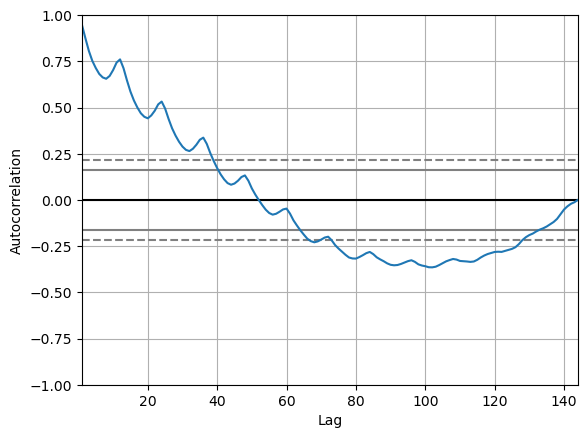

In [17]:
# Detect autocorrelation with pandas module
#Obtain the same but with single line and more info...
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.Passengers) 
#Horizontal bands indicate 95% and 99% (dashed) confidence bands

In [18]:
# In the graph one can see, that for smaller lags than 40 there is a 99% confidence of positive autocorrelation

# ARIMA Time Series Forecasting

In [19]:
from pmdarima.arima import auto_arima
#Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components

In [25]:
# In this step the an auto arima process is applies to check which of the ARIMA models and with which parameters fit the data best
# Note that in this case the auto arima is only allowed to check 50 times which model fits best <-- with this value can be played around to see how results change
# Thereby the AIC metric (relative quality of statistical models) 
arima_model = auto_arima(df['Passengers'], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50)  

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.20 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1020.582, Time=0.44 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.57 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.32 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.56 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.14 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.26 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.36 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.21 sec
 ARIMA(0,1,1)(1,1,0)[12]     

In [26]:
# Print the summary of the auto arima process which displays the suggested ARIMA model with the coressponding parameters
# Look at row "Model" to find the suggestions

print(arima_model.summary() ) 

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Fri, 14 Jul 2023   AIC                           1019.178
Time:                                     11:49:13   BIC                           1030.679
Sample:                                 01-01-1949   HQIC                          1023.851
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      

In [27]:
# Split data into train and test
# Here 66% of data is used for training and the remaining for testing
size = int(len(df) * 0.66)
X_train, X_test = df[0:size], df[size:len(df)]

In [28]:
# Import and use the suggested ARIMA model from auto arima process
from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [29]:
# The suggested ARIMA model is the SARIMAX(0, 1, 1)x(2, 1, [], 12)
# In this line of code we create an model to the training data
model = SARIMAX(X_train['Passengers'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 1, 12)) 

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [30]:
# Now we fit/ train the model to the data and plot the summary of that process
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                   95
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -300.268
Date:                            Fri, 14 Jul 2023   AIC                            610.537
Time:                                    11:54:08   BIC                            622.571
Sample:                                01-01-1949   HQIC                           615.368
                                     - 11-01-1956                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3191      0.103     -3.091      0.002      -0.521      -0.117
ar.S.L12       0.6861      0.567      1.210      0.226      -0.426       1.798
ar.S.L24       0.3128      0.133      2.353      0.019       0.052       0.573
ma.S.L12      -0.9820      5.371     -0.183      0.855     -11.510       9.546
sigma2        78.5811    377.900      0.208      0.835    -662.090     819.252
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.55
Prob(Q):                              0.95   Prob(JB):                         0.28
Heteroskedasticity (H):               1.68   Skew:                             0.42
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# Makes predictions to the already seen training data
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index) 

In [32]:
# Makes predictions to newely never seen data
start_index = len(X_train)
end_index = len(df)-1
prediction = result.predict(start_index, end_index).rename('Predicted passengers') 

<Axes: xlabel='Month'>

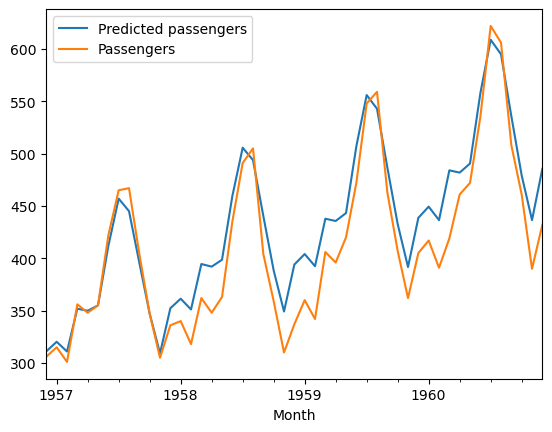

In [33]:
# plot predictions and actual values 
prediction.plot(legend = True) 
X_test['Passengers'].plot(legend = True) 

In [35]:
X_train.shape

(95, 3)

In [36]:
train_prediction.shape

(95,)

In [39]:
# Now we can calculate the accuarcy of the prediction by computing the root of mean squared error

import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train['Passengers'], train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test['Passengers'], prediction))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 16.14 RMSE
Test Score: 29.40 RMSE


In [41]:
# The next step is to forecast data that not even in the dataset using the model
# To do this it is advicable to train the model to the whole dataset

# Sets up the model
model_whole_dataset = SARIMAX(df['Passengers'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 1, 12)) 

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [42]:
# Fits/ trains the model to the data
result_whole_dataset = model_whole_dataset.fit() 
result_whole_dataset.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -501.959
Date:                            Fri, 14 Jul 2023   AIC                           1013.919
Time:                                    12:22:43   BIC                           1028.295
Sample:                                01-01-1949   HQIC                          1019.760
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4240      0.068     -6.215      0.000      -0.558      -0.290
ar.S.L12       0.6672      0.148      4.502      0.000       0.377       0.958
ar.S.L24       0.3312      0.096      3.441      0.001       0.143       0.520
ma.S.L12      -0.9739      1.129     -0.863      0.388      -3.186       1.238
sigma2       110.7241    104.009      1.065      0.287     -93.130     314.579
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 7.57
Prob(Q):                              0.92   Prob(JB):                         0.02
Heteroskedasticity (H):               2.80   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
# Forecasts the data for the next 3 years

forecast = result_whole_dataset.predict(start = len(df),  
                          end = (len(df)-1) + 3 * 12,  
                          typ = 'levels').rename('Forecast') 

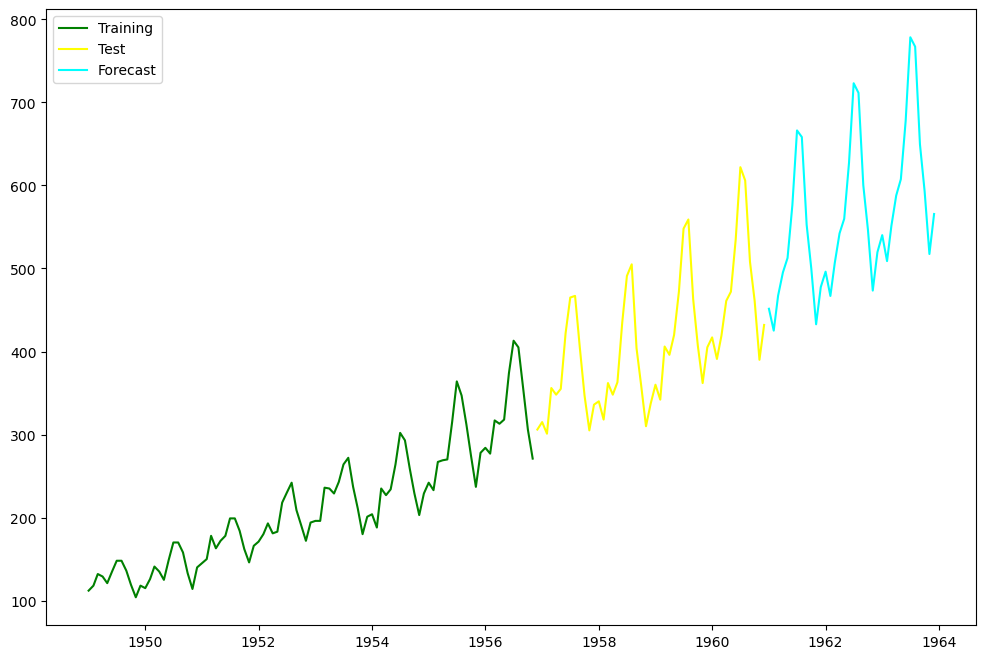

In [58]:
# Plots the forecast results
plt.figure(figsize=(12,8))
plt.plot(X_train['Passengers'], label='Training', color='green')
plt.plot(X_test['Passengers'], label='Test', color='yellow')
plt.plot(forecast, label='Forecast', color='cyan')
plt.legend(loc='upper left')
plt.show()